In [7]:
import cv2         
import numpy as np  
import pydicom
import matplotlib.pyplot as plt
import os
from PIL import Image
np.set_printoptions(threshold=np.inf)

Threshold value: 44.0


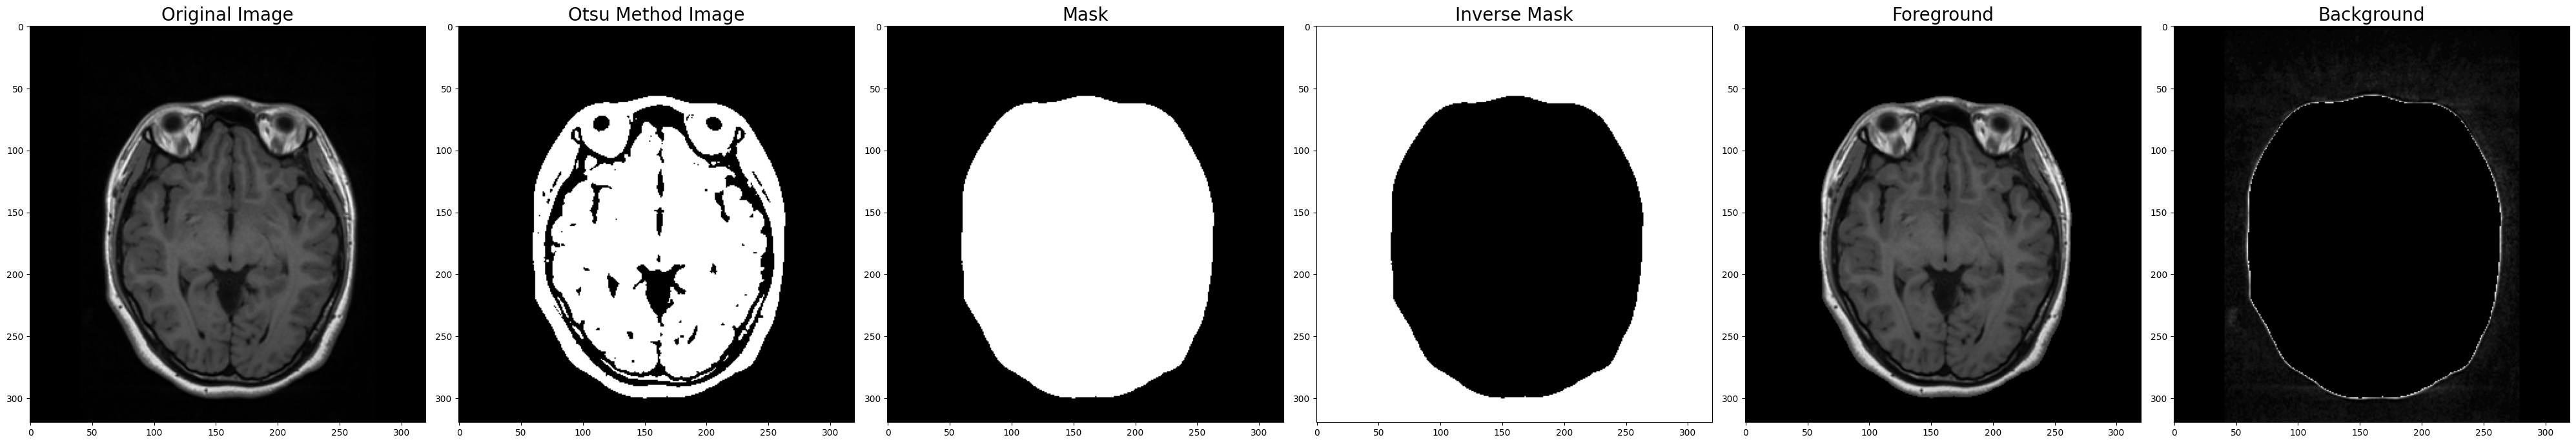

In [8]:
file = os.path.join(os.getcwd(), 'test.dcm')

#Read dicom file
img = pydicom.dcmread(file)
img = img.pixel_array

# Normalize the Image
normalize = img / np.iinfo(img.dtype).max

# Convert the normalized image to 8-bit
normalize = cv2.normalize(normalize, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)


# Apply Otsu threshold

ret, thresh1 = cv2.threshold(normalize,0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"Threshold value: {ret}")




# Threshold the image
_, mask = cv2.threshold(normalize, ret, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Fill in the contours
for contour in contours:
    cv2.drawContours(mask, [contour], 0, (255), thickness=cv2.FILLED)

inverse_mask = np.invert(mask)

# # Create a mask from the thresholded image
# mask = thresh1 > 0
# inverse_mask = np.invert(mask)


foreground = cv2.bitwise_and(normalize, normalize, mask=mask.astype("uint8"))

# To extract the background, you can invert the mask and then use it
inverse_mask = cv2.bitwise_not(mask)  # Invert the mask
background = cv2.bitwise_and(normalize, normalize, mask=inverse_mask.astype("uint8"))

# # Create new RGBA image and paste segmented part using mask
# foreground = Image.new("RGBA", img.shape, (0, 0, 0, 0))  # Create new blank (transparent) image
# image_pil = Image.fromarray(normalize).convert("RGBA")  # Convert the normalized image to RGBA
# foreground.paste(image_pil, mask=mask)  # Paste in the segmented part using the mask




# #DISPLAY
# plt.figure(figsize=(40,20))

# plt.subplot(1,5,1)
# plt.title('Original Image',fontsize=20)
# plt.imshow(normalize,cmap='gray')

# plt.subplot(1,5,2)
# plt.title('Otsu Method Image',fontsize=20)
# plt.imshow(thresh1,cmap='gray')

# plt.subplot(1,5,3)
# plt.title('Mask',fontsize=20)
# plt.imshow(mask,cmap='gray')

# # plt.subplot(1,5,4)
# # plt.title('Inverse Mask',fontsize=20)
# # plt.imshow(inverse_mask,cmap='gray')

# plt.subplot(1,5,4)
# plt.title('Foreground',fontsize=20)
# plt.imshow(foreground,cmap='gray')

# plt.subplot(1,5,5)
# plt.title('Background',fontsize=20)
# plt.imshow(background,cmap='gray')

# plt.tight_layout()





In [104]:
print(f"Normal: {foreground}")



Normal: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0 

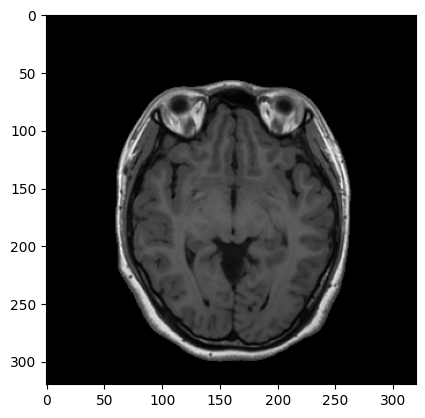

In [9]:
# SHOW DIFFERENCE

diff = cv2.absdiff(normalize,background)
plt.imshow(diff, cmap='gray')

### METHOD 2

In [106]:
# Read DICOM file
file = os.path.join(os.getcwd(), 'test.dcm')
img = pydicom.dcmread(file)
img = img.pixel_array

# Normalize the image
normalize = img / np.iinfo(img.dtype).max

# Convert the normalized image to 8-bit
normalize = cv2.normalize(normalize, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Apply Otsu threshold
ret, thresh1 = cv2.threshold(normalize, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Create a mask from the thresholded image
mask = thresh1 > 0

# Convert mask to PIL Image for easier manipulation
mask = Image.fromarray(mask)

# Create new RGBA image and paste segmented part using mask
foreground = Image.new("RGBA", img.shape, (0, 0, 0, 0))  # Create new blank (transparent) image
image_pil = Image.fromarray(normalize).convert("RGBA")  # Convert the normalized image to RGBA
foreground.paste(image_pil, mask=mask)  # Paste in the segmented part using the mask

# Display the resulting image
foreground.show()

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/braillic/snap/code/common/.cache/gio-modules/libgiolibproxy.so
eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE
